## The Goal: Similar analysis as before, but use magnitude of full surface winds (U and V) and sum of their variances. 
<b>Author:</b> Meg Fowler <br>
<b>Date:</b> 19 Sept 2020 
<br>

In [1]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
import Ngl
import numpy
import Nio
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import regionmask
import pickle

## Read in data

In [2]:
# Set up directories 
dataDir    = '/Users/meganfowler/Documents/NCAR/Analysis/CLUBB_initial/data/'
nameStart  = 'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.'
nameEnd    = '_CLUBBwinds.nc'
nameEnd_UV = '_UV.nc'
nameEnd_W  = '_W.nc'
nameEnd_PBLH = '_PBLH.nc'

#decadeList = ['1951-59','1960-69', '1970-79','1980-89','1990-99','2000-14']
decadeList = ['1970-79','1980-89','1990-99','2000-14']


In [3]:
# Read in example file to get some constant fields
testName = dataDir+nameStart+'1990-01.nc'
testDF   = xr.open_dataset(testName)

# Set lat, lon 
lat = testDF.lat
lon = testDF.lon

# Make land mask
landFrac = np.squeeze(testDF.LANDFRAC.values)
# Define as 'land' gridcell if land fraction > 0.5
landMask = np.full([len(lat),len(lon)],np.nan)
landMask[landFrac > 0.5] = 1


In [4]:
# Read in data by decade 
for iDec in range(len(decadeList)): 
    
    # Open datasets for each decade 
    fileName = dataDir+nameStart+decadeList[iDec]+nameEnd
    dataDF   = xr.open_dataset(fileName, decode_times=True)
    dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    UVfile = dataDir+nameStart+decadeList[iDec]+nameEnd_UV 
    windDF = xr.open_dataset(UVfile, decode_times=True)
    windDF['time'] = windDF.indexes['time'].to_datetimeindex()
    
#     Wfile = dataDir+nameStart+decadeList[iDec]+nameEnd_W
#     vertDF = xr.open_dataset(Wfile, decode_times=True)
#     vertDF['time'] = vertDF.indexes['time'].to_datetimeindex()
    
#     PSfile = dataDir+nameStart+decadeList[iDec]+'_PS.nc'
#     presDF = xr.open_dataset(PSfile, decode_times=True)
#     presDF['time'] = presDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

#     PBLHfile = dataDir+nameStart+decadeList[iDec]+nameEnd_PBLH
#     pblhDF   = xr.open_dataset(PBLHfile, decode_times=True)
#     pblhDF['time'] = pblhDF.indexes['time'].to_datetimeindex()

    # Create *giant* datasets that span the full period of the simulations
    if iDec==0:
        fullDF = dataDF
        fullUV = windDF
#         fullPBLH = pblhDF
#         fullW  = vertDF
#         fullPS = presDF
    else:
        fullDF = xr.concat([fullDF, dataDF], dim="time")
        fullUV = xr.concat([fullUV, windDF], dim="time")
#         fullPBLH = xr.concat([fullPBLH, pblhDF], dim="time")
#         fullW  = xr.concat([fullW,  vertDF], dim="time")
#         fullPS = xr.concat([fullPS, presDF], dim="time")
        
    print('Done with decade ', decadeList[iDec], ' ... ')
    print('    Number of times saved: ', len(fullDF['time']))
    

<ipython-input-4-d22d649ae8cf>:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime
<ipython-input-4-d22d649ae8cf>:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  windDF['time'] = windDF.indexes['time'].to_datetimeindex()


Done with decade  1970-79  ... 
    Number of times saved:  120
Done with decade  1980-89  ... 
    Number of times saved:  240
Done with decade  1990-99  ... 
    Number of times saved:  360
Done with decade  2000-14  ... 
    Number of times saved:  540


In [5]:
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(fullDF['time'].values) 

# Let's set the monthly averages to be roughly mid-month
#   This way, the average for January has a month of 1 instead of being the first day of February 
midTime = dates - timedelta(days=15)       # Get new dates array that has the right month/year in it 


## Flip levels and do some minimal processing 

In [16]:
# Read into individual arrays for easy access

UP2 = fullDF.UP2_CLUBB.values      # Zonal velocity variance (m2/s2)
VP2 = fullDF.VP2_CLUBB.values      # Meridional velocity variance (m2/s2)
# WP2 = fullDF.WP2_CLUBB.values    # Vertical velocity variance (m2/s2)
# WP3 = fullDF.WP3_CLUBB.values    # Third moment vertical velocity (m3/s3)
# PBLH = fullPBLH.PBLH.values

U   = fullUV.U.values              # Zonal wind (m/s)
V   = fullUV.V.values             # Meridional wind (m/s)
#W   = fullW.W.values              # Vertical velocity (m/s) -- script to compute on /glade/work/mdfowler/...



In [17]:
# Flip along vertical (level) axis, so that index 0 is surface 

UP2 = np.flip(UP2, axis=1)
VP2 = np.flip(VP2, axis=1)
# WP2 = np.flip(WP2, axis=1)
# WP3 = np.flip(WP3, axis=1)

U   = np.flip(U, axis=1)
V   = np.flip(V, axis=1)
#W   = np.flip(W, axis=1)

# Save levels themselves to arrays and flip them 
lev_interface = np.flip(fullDF.ilev.values)
lev_middle    = np.flip(fullUV.lev.values)


In [18]:
# Now get surface wind magnitude and combine variances 
windSpd = np.sqrt(U**2 + V**2)
windVar = UP2 + VP2 


In [19]:
# Sanity check that worked how I think it should 
print(windSpd[100,2,87,60])
print(np.sqrt( ((U[100,2,87,60])**2) + ((V[100,2,87,60])**2)  ))

7.0219536
7.021953423975367


## Start with a few maps of wind speed and variance 

In [13]:
# Get seasonal indices 
iDJF = np.where((midTime.month==12) | (midTime.month<=2))[0]
iMAM = np.where((midTime.month>=3)  & (midTime.month<=5))[0]
iJJA = np.where((midTime.month>=6)  & (midTime.month<=8))[0]
iSON = np.where((midTime.month>=9)  & (midTime.month<=11))[0]


In [20]:
# Select near surface speed and variance 
sfcWindSpd = windSpd[:,0,:,:]
sfcWindVar = windVar[:,1,:,:]


**Plot seasonal means**

In [23]:
# Compute means 
seasonalWindSpd = np.full([4, len(lat), len(lon)], np.nan)
seasonalWindVar = np.full([4, len(lat), len(lon)], np.nan)
seasonalTitles  = np.asarray(['DJF','MAM','JJA','SON'])

seasonalWindSpd[0,:,:] = np.nanmean(sfcWindSpd[iDJF,:,:], axis=0)
seasonalWindSpd[1,:,:] = np.nanmean(sfcWindSpd[iMAM,:,:], axis=0)
seasonalWindSpd[2,:,:] = np.nanmean(sfcWindSpd[iJJA,:,:], axis=0)
seasonalWindSpd[3,:,:] = np.nanmean(sfcWindSpd[iSON,:,:], axis=0)

seasonalWindVar[0,:,:] = np.nanmean(sfcWindVar[iDJF,:,:], axis=0)
seasonalWindVar[1,:,:] = np.nanmean(sfcWindVar[iMAM,:,:], axis=0)
seasonalWindVar[2,:,:] = np.nanmean(sfcWindVar[iJJA,:,:], axis=0)
seasonalWindVar[3,:,:] = np.nanmean(sfcWindVar[iSON,:,:], axis=0)


In [27]:
np.nanmax(seasonalWindVar)

1.703253149986267

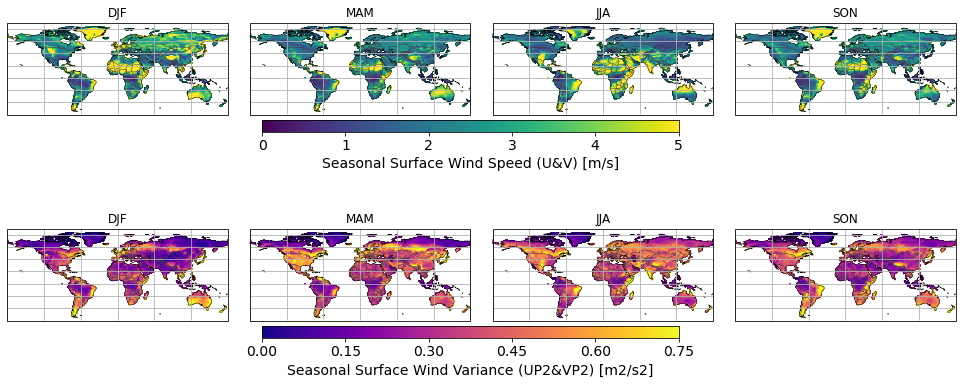

In [44]:
# Set up figure 
fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# --- Start plotting ---- 
for iSeason in range(4): 
    axs[iSeason+0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())
    contour_plot = axs[iSeason+0].pcolormesh(lon,lat,seasonalWindSpd[iSeason,:,:]*landMask,
                           vmin = 0,
                           vmax = 5, 
                           cmap = 'viridis')
    axs[iSeason+0].gridlines()
    axs[iSeason+0].coastlines(linewidth=0.5,edgecolor='0.25')
    axs[iSeason+0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
    axs[iSeason+0].set_title(seasonalTitles[iSeason])
    
    # Add colorbar 
    if iSeason==1: 
        ax_position = axs[iSeason].get_position()
        cbar_ax     = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.03, ax_position.width+0.16, 0.02])
        cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
        # Control number of ticks via 'ticker' in matplotlib 
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        # Set label and fontsize
        cbar.set_label('Seasonal Surface Wind Speed (U&V) [m/s]',fontsize=14)
        cbar.ax.tick_params(labelsize=14)
    
    
    
    
    axs[iSeason+4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())
    contour_plot = axs[iSeason+4].pcolormesh(lon,lat,seasonalWindVar[iSeason,:,:]*landMask,
                           vmin = 0,
                           vmax = 0.75, 
                           cmap = 'plasma')
    axs[iSeason+4].gridlines()
    axs[iSeason+4].coastlines(linewidth=0.5,edgecolor='0.25')
    axs[iSeason+4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
    axs[iSeason+4].set_title(seasonalTitles[iSeason])
    
    # Add colorbar 
    if iSeason==1:
        ax_position = axs[iSeason+4].get_position()
        cbar_ax     = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.03, ax_position.width+0.16, 0.02])
        cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
        # Control number of ticks via 'ticker' in matplotlib 
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        # Set label and fontsize
        cbar.set_label('Seasonal Surface Wind Variance (UP2&VP2) [m2/s2]',fontsize=14)
        cbar.ax.tick_params(labelsize=14)
    
    


## Take a look at ratio of magnitude and SGS standard deviation 

In [45]:
# Get std rather than variance 
sfcWindStd = np.sqrt(sfcWindVar)

# Look at fraction of Ustd vs. magnitude of wind speed
STDfraction = sfcWindStd / (sfcWindSpd+sfcWindStd)  # Closer to 1 = std a bigger portion of U 


In [46]:
# Get seasonal means of that fraction 
seasonalStdFraction = np.full([4, len(lat), len(lon)], np.nan)

seasonalStdFraction[0,:,:] = np.nanmean(STDfraction[iDJF,:,:], axis=0)
seasonalStdFraction[1,:,:] = np.nanmean(STDfraction[iMAM,:,:], axis=0)
seasonalStdFraction[2,:,:] = np.nanmean(STDfraction[iJJA,:,:], axis=0)
seasonalStdFraction[3,:,:] = np.nanmean(STDfraction[iSON,:,:], axis=0)


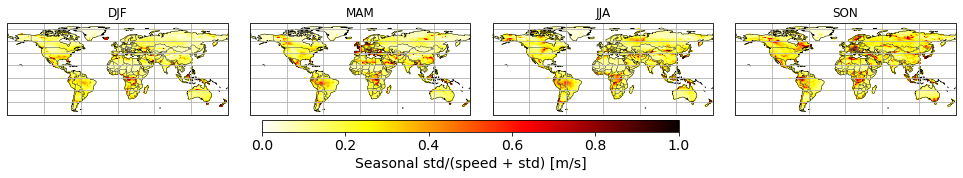

In [50]:
# Set up figure 
fig, axs = plt.subplots(1,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# --- Start plotting ---- 
for iSeason in range(4): 
    axs[iSeason+0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())
    contour_plot = axs[iSeason+0].pcolormesh(lon,lat,STDfraction[iSeason,:,:]*landMask,
                           vmin = 0,
                           vmax = 1, 
                           cmap = 'hot_r')
    axs[iSeason+0].gridlines()
    axs[iSeason+0].coastlines(linewidth=0.5,edgecolor='0.25')
    axs[iSeason+0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
    axs[iSeason+0].set_title(seasonalTitles[iSeason])
    
    # Add colorbar 
    if iSeason==1: 
        ax_position = axs[iSeason].get_position()
        cbar_ax     = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.03, ax_position.width+0.16, 0.02])
        cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
        # Control number of ticks via 'ticker' in matplotlib 
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        # Set label and fontsize
        cbar.set_label('Seasonal std/(speed + std) [m/s]',fontsize=14)
        cbar.ax.tick_params(labelsize=14)
    

## Regional 2D histograms